In [14]:
import numpy as np
import pandas as pd
import pickle
pd.options.mode.chained_assignment = None
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.decomposition import PCA

In [15]:
cars_fc = pd.read_csv('model_input.csv')
cars_fc_target = cars_fc.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
cars_fc_data = cars_fc.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')

In [16]:
data_train, data_test, target_train, target_test = train_test_split(cars_fc_data, cars_fc_target, test_size=0.2, random_state=23)

Validation and testing functions

In [26]:
def analyze(x_train, x_test, y_train, y_test, reg):

    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    
    y_test = y_test.to_numpy().flatten()
    
    print(np.mean(y_pred))
    print(f"Absolute error: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"Squared error: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"Max error: {metrics.max_error(y_test, y_pred)}")
    
    return y_test, y_pred

def cross_validation(data, target, reg):
    kf = KFold(n_splits=5, shuffle=True, random_state=23)
    return cross_validate(reg, data, target, scoring='neg_mean_squared_error', cv=kf)

Linear regression

In [70]:
std = StandardScaler()
data_train_t = std.fit_transform(data_train)
data_test_t = std.transform(data_test)

reg = LinearRegression()

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.0081718 , 0.00871253, 0.01031423, 0.00869298, 0.01184058]),
 'score_time': array([0.002424  , 0.00229526, 0.0035913 , 0.00257707, 0.00354004]),
 'test_score': array([-3.07193472, -2.37431752, -3.00747952, -2.18737435, -2.28900288])}

Polynomial regression

In [71]:
std = StandardScaler()
data_train_t = std.fit_transform(data_train)
data_test_t = std.transform(data_test)

pol = PolynomialFeatures()
data_train_t = pol.fit_transform(data_train_t)
data_test_t = pol.transform(data_test_t)

reg = LinearRegression()

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.56854129, 0.58433819, 1.15675235, 0.68850851, 0.54430842]),
 'score_time': array([0.00199986, 0.00299907, 0.00352454, 0.0022316 , 0.00820923]),
 'test_score': array([-1.22441391e+17, -7.27794910e+15, -4.95109531e+17, -1.99114604e+18,
        -1.16574508e+19])}

Polynomial regression with regularization

In [49]:
def poly_reg_t(data_tr, data_te): 
    std = StandardScaler()
    data_tr_t = std.fit_transform(data_tr)
    data_te_t = std.transform(data_te)
    
    pol = PolynomialFeatures()
    data_tr_t = pol.fit_transform(data_tr_t)
    data_te_t = pol.transform(data_te_t)
    
    return data_tr_t, data_te_t

In [72]:
data_train_t, data_test_t = poly_reg_t(data_train, data_test)

reg = ElasticNet(alpha=0.01, max_iter=20000)

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.90537286, 1.93469548, 1.58868265, 1.47778249, 1.31531549]),
 'score_time': array([0.00200081, 0.00153613, 0.00157952, 0.00230026, 0.00213933]),
 'test_score': array([-1.52159966, -1.27670426, -1.50824324, -1.1490903 , -1.21246995])}

Polynomial regression after PCA

In [74]:
std = StandardScaler()
data_train_t = std.fit_transform(data_train)
data_test_t = std.transform(data_test)

pca = PCA()
data_train_t = pca.fit_transform(data_train_t)
data_test_t = pca.transform(data_test_t)

pol = PolynomialFeatures()
data_train_t = pol.fit_transform(data_train_t)
data_test_t = pol.transform(data_test_t)

reg = ElasticNet(alpha=0.05, max_iter=50000)

# analyze(data_train_t, data_test_t, target_train, target_test, reg)
cv = cross_validation(data_train_t, target_train, reg)
cv
# np.average(cv['test_score'])

{'fit_time': array([0.59573483, 0.77770972, 0.15549445, 0.79056978, 0.80855179]),
 'score_time': array([0.00902367, 0.00226426, 0.00299978, 0.0035243 , 0.00212669]),
 'test_score': array([-1.64919907, -1.53048124, -1.72455263, -1.26327793, -1.3946261 ])}

Grid search

In [15]:
def grid_EN(data, target):
    params = {'alpha': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 10, 20, 50], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
    kf = KFold(n_splits=5, shuffle=True)
    
    std = StandardScaler()
    t_data = std.fit_transform(data)
    
    pol = PolynomialFeatures()
    t_data = pol.fit_transform(t_data)
    
    reg = ElasticNet(max_iter=80000)
    
    grid_search = GridSearchCV(estimator=reg,
                           param_grid=params,
                           scoring='neg_mean_squared_error',
                           cv=kf,
                           return_train_score=True,
                           verbose=2)
    
    grid_search.fit(t_data, target)
    
    return grid_search

In [16]:
grid_res = grid_EN(data_train, target_train)
pd.DataFrame(grid_res.cv_results_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  21.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  39.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  24.8s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  26.9s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  34.8s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  13.2s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  32.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  21.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  34.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  23.9s
[CV] END ..........................alpha=0.001, l1_ratio=0.3; total time=  11.2s
[CV] END ..........................alpha=0.001

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,29.613425,6.658918,0.002207,0.000154,0.001,0.1,"{'alpha': 0.001, 'l1_ratio': 0.1}",-1.554185,-1.381677,-1.640333,...,-1.505403,0.094609,30,-0.863103,-0.852934,-0.843602,-0.856418,-0.867988,-0.856809,0.008416
1,25.044870,7.709468,0.002035,0.000469,0.001,0.2,"{'alpha': 0.001, 'l1_ratio': 0.2}",-1.552847,-1.372824,-1.633220,...,-1.494813,0.097257,27,-0.864721,-0.854998,-0.845695,-0.858523,-0.869734,-0.858734,0.008257
2,20.526025,6.734122,0.002268,0.000730,0.001,0.3,"{'alpha': 0.001, 'l1_ratio': 0.3}",-1.551943,-1.364164,-1.626744,...,-1.489155,0.096626,26,-0.866436,-0.857257,-0.847920,-0.860787,-0.871608,-0.860801,0.008087
3,18.484836,8.257915,0.002440,0.000679,0.001,0.4,"{'alpha': 0.001, 'l1_ratio': 0.4}",-1.552468,-1.354890,-1.622904,...,-1.484455,0.097748,25,-0.868198,-0.859516,-0.850446,-0.863300,-0.873714,-0.863035,0.007895
4,16.185346,8.386245,0.002406,0.000641,0.001,0.5,"{'alpha': 0.001, 'l1_ratio': 0.5}",-1.549706,-1.345428,-1.620715,...,-1.482189,0.097890,22,-0.869892,-0.861905,-0.852690,-0.865780,-0.876035,-0.865260,0.007837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.029114,0.001580,0.002066,0.000432,50,0.5,"{'alpha': 50, 'l1_ratio': 0.5}",-18.189632,-18.257267,-14.898622,...,-16.934335,1.305193,164,-16.611949,-16.594474,-17.436120,-16.827205,-17.161807,-16.926311,0.326841
176,0.028792,0.001043,0.002631,0.000406,50,0.6,"{'alpha': 50, 'l1_ratio': 0.6}",-18.189632,-18.257267,-14.898622,...,-16.934335,1.305193,164,-16.611949,-16.594474,-17.436120,-16.827205,-17.161807,-16.926311,0.326841
177,0.029661,0.000823,0.002096,0.000385,50,0.7,"{'alpha': 50, 'l1_ratio': 0.7}",-18.189632,-18.257267,-14.898622,...,-16.934335,1.305193,164,-16.611949,-16.594474,-17.436120,-16.827205,-17.161807,-16.926311,0.326841
178,0.029661,0.001485,0.002604,0.000393,50,0.8,"{'alpha': 50, 'l1_ratio': 0.8}",-18.189632,-18.257267,-14.898622,...,-16.934335,1.305193,164,-16.611949,-16.594474,-17.436120,-16.827205,-17.161807,-16.926311,0.326841


Result save

In [17]:
with open('single_grid.pkl', 'wb') as file:
    pickle.dump(grid_res, file)

Result load

In [18]:
with open('single_grid.pkl', 'rb') as file:
    grid_res = pickle.load(file)

In [19]:
grid_res.best_params_

{'alpha': 0.01, 'l1_ratio': 0.6}

In [27]:
data_train_t, data_test_t = poly_reg_t(data_train, data_test)

reg = ElasticNet(alpha=grid_res.best_params_['alpha'], l1_ratio=grid_res.best_params_['l1_ratio'], max_iter=50000)

single_res = analyze(data_train_t, data_test_t, target_train, target_test, reg)

9.939945191588949
Absolute error: 0.8518893906995679
Squared error: 1.3957428768566507
Max error: 5.647967441359226


Grid search on on two models splitted by engine boost type

In [20]:
value = [True, False]

for val in value:
    # train set split by boost type
    data_con = pd.concat([data_train, target_train], axis=1)
    data_con = data_con.loc[data_con['boost_type_none'] == val]
    data_con = data_con.drop(['boost_type_none'], axis='columns')

    target_train_s = data_con.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
    data_train_s = data_con.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')
    
    # model training
    if val:
        grid_na = grid_EN(data_train_s, target_train_s)
    else:
        grid_tu = grid_EN(data_train_s, target_train_s)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  20.6s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  20.6s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  27.8s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  24.7s
[CV] END ..........................alpha=0.001, l1_ratio=0.1; total time=  25.0s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  11.6s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  16.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  23.7s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  20.5s
[CV] END ..........................alpha=0.001, l1_ratio=0.2; total time=  17.1s
[CV] END ..........................alpha=0.001, l1_ratio=0.3; total time=  10.0s
[CV] END ..........................alpha=0.001

In [21]:
with open('double_grid_na.pkl', 'wb') as file:
    pickle.dump(grid_na, file)
with open('double_grid_tu.pkl', 'wb') as file:
    pickle.dump(grid_tu, file)

In [20]:
with open('double_grid_na.pkl', 'rb') as file:
    grid_na = pickle.load(file)
with open('double_grid_tu.pkl', 'rb') as file:
    grid_tu = pickle.load(file)

In [62]:
grid_tu.best_params_

{'alpha': 0.05, 'l1_ratio': 0.2}

In [21]:
def double_analyze(x_train, x_test, y_train, y_test, reg):
    
    y_pred = []
    sum_test = []
    
    value = [True, False]

    for i, val in enumerate(value):
        # train set split by boost type
        data_con = pd.concat([x_train, y_train], axis=1)
        data_con = data_con.loc[data_con['boost_type_none'] == val]
        data_con = data_con.drop(['boost_type_none'], axis='columns')
    
        y_train_s = data_con.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
        x_train_s = data_con.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')
        
        # test set split by boost type
        data_con = pd.concat([x_test, y_test], axis=1)
        data_con = data_con.loc[data_con['boost_type_none'] == val]
        data_con = data_con.drop(['boost_type_none'], axis='columns')
    
        y_test_s = data_con.loc[:, ['mixed_fuel_consumption_per_100_km_l']]
        x_test_s = data_con.drop(['mixed_fuel_consumption_per_100_km_l'], axis='columns')
        
        x_train_s, x_test_s = poly_reg_t(x_train_s, x_test_s)
    
        reg[i].fit(x_train_s, y_train_s)
        y_pred.append(reg[i].predict(x_test_s))
        sum_test.append(y_test_s.to_numpy().flatten())
    
    y_pred = np.concatenate(y_pred)
    y_test = np.concatenate(sum_test)
    
    print(np.mean(y_pred))
    print(f"Absolute error: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"Squared error: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"Max error: {metrics.max_error(y_test, y_pred)}")
    
    return y_test, y_pred

In [22]:
reg = (ElasticNet(alpha=grid_na.best_params_['alpha'], l1_ratio=grid_na.best_params_['l1_ratio'], max_iter=50000), ElasticNet(alpha=grid_tu.best_params_['alpha'], l1_ratio=grid_tu.best_params_['l1_ratio'], max_iter=50000))

double_res = double_analyze(data_train, data_test, target_train, target_test, reg)

9.929710634040646
Absolute error: 0.8344998737592638
Squared error: 1.3746007526545687
Max error: 5.6655097974712465


Making residuals plots

In [59]:
from matplotlib import pyplot as plt

def res_plot(y_true, y_pred):
    residuals = y_true - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    standardized_residuals = (residuals - mean_residual) / std_residual
    
    plt.figure(figsize=(12,4))
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Błąd predykcji dla każdego samochodu')
    plt.xlabel('Wartości predykowane')
    plt.ylabel('Błąd predykcji')
    plt.show()

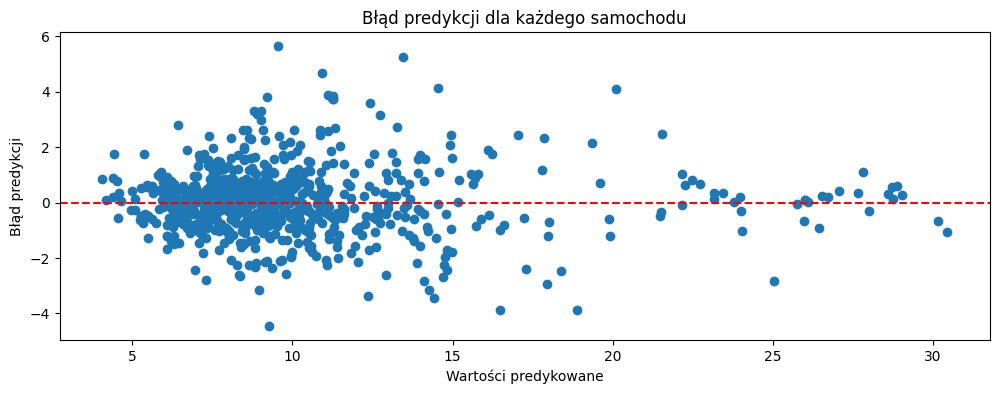

In [77]:
res_plot(*single_res)

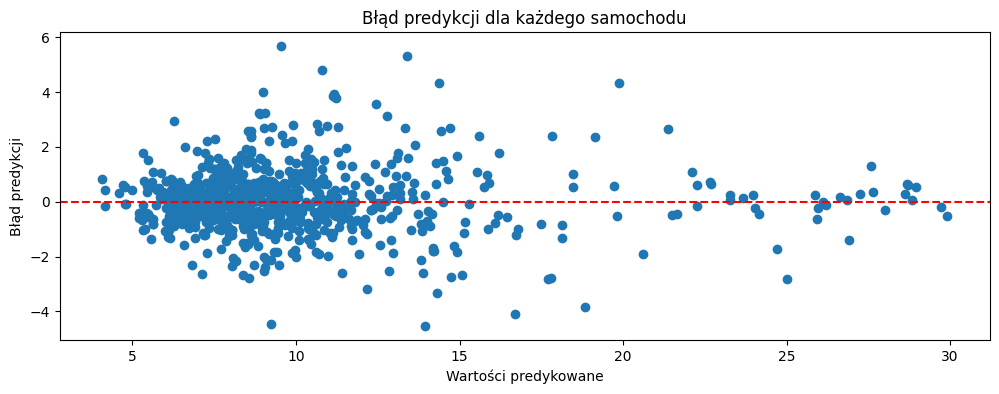

In [78]:
res_plot(*double_res)

In [68]:
metrics.mean_absolute_error(*single_res) / np.mean(single_res[0])

0.08540296344566203

In [76]:
metrics.mean_absolute_error(*double_res) / np.mean(double_res[0])

0.08365964289747332